Run on NERSC

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def plot_cutout(img, pixscale, decraoff=None, vmin=-1, vmax=1, unit='arcsec', axis_label=None, colorbar=False, cbar_label=None, title=None, axis=None, figsize=(8, 8)):
    '''
    decraoff: [dec_offset, ra_offset]
    '''
    if unit=='arcsec':
        rescale = 1.
    elif unit=='arcmin':
        rescale = 60.
    elif unit=='deg':
        rescale = 3600.
    else:
        raise ValueError('unrecognized unit')
    extent = 0.5*pixscale*(img.shape[1]*np.array([-1, 1, 0, 0])+img.shape[0]*np.array([0, 0, -1, 1]))/rescale

    if decraoff is not None:
        dec_offset, ra_offset = decraoff
        extent[0] -= dec_offset # DEC
        extent[1] -= dec_offset # DEC
        extent[2] += ra_offset # RA
        extent[3] += ra_offset # RA
    
    fig, ax = plt.subplots(figsize=figsize)
    dens = ax.imshow(img, aspect='equal',
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    if colorbar:
        cbar = fig.colorbar(dens, fraction=0.046, pad=0.04)
    if cbar_label is not None:
        cbar.ax.set_ylabel(cbar_label)
    ax.grid(alpha=0.5)
    if axis_label is not None:
        ax.set_xlabel(axis_label[0])
        ax.set_ylabel(axis_label[1])
    if title is not None:
        ax.set_title(title)
    if axis is not None:
        ax.axis(axis)
    return ax

def plot_cutout_sidebyside(img1, img2, pixscale, decraoff=None, vmin=-1, vmax=1, unit='arcsec', axis_label=None, axis=None, title1=None, title2=None, figsize=(20, 10), crosshair=True, grid=False):
    '''
    decraoff: [dec_offset, ra_offset]
    '''
    if unit=='arcsec':
        rescale = 1.
    elif unit=='arcmin':
        rescale = 60.
    elif unit=='deg':
        rescale = 3600.
    else:
        raise ValueError('unrecognized unit')
    extent = 0.5*pixscale*(img1.shape[1]*np.array([-1, 1, 0, 0])+img1.shape[0]*np.array([0, 0, -1, 1]))/rescale

    if decraoff is not None:
        dec_offset, ra_offset = decraoff
        extent[0] -= dec_offset # DEC
        extent[1] -= dec_offset # DEC
        extent[2] += ra_offset # RA
        extent[3] += ra_offset # RA
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].imshow(img1, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    if crosshair:
        axes[0].axvline(0, ls='--', lw=0.5, color='grey')
        axes[0].axhline(0, ls='--', lw=0.5, color='grey')
    if title1 is not None:
        axes[0].set_title(title1)
    im = axes[1].imshow(img2, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    axes[1].axvline(0, ls='--', lw=0.5, color='grey')
    axes[1].axhline(0, ls='--', lw=0.5, color='grey')
    if title2 is not None:
        axes[1].set_title(title2)
    if axis_label is not None:
        axes[0].set_xlabel(axis_label[0])
        axes[0].set_ylabel(axis_label[1])
        axes[1].set_xlabel(axis_label[0])
        axes[1].set_ylabel(axis_label[1])
    # fig.colorbar(im, fraction=0.046, pad=0.04)
    if grid:
        axes[0].grid(alpha=0.5)
        axes[1].grid(alpha=0.5)
    if axis is not None:
        axes[0].axis(axis)
        axes[1].axis(axis)
    return axes

In [4]:
from scipy.optimize import curve_fit

def get_frac_moffat(r, alpha, beta):
    """
    Calculate the fraction of light within radius r of a Moffat profile.
    """    
    frac = 1 - alpha**(2*(beta-1))*(alpha**2 + r**2)**(1-beta)
    return(frac)

def get_sb_moffat(r, alpha, beta):
    """
    Calculate the surface brightness of light at radius r of a Moffat profile.
    The integral (i.e., total flux) is unity by definition.
    """
    i = (beta-1)/(np.pi * alpha**2)*(1 + (r/alpha)**2)**(-beta)
    return i

def get_sb_moffat_plus_power_law(r, alpha1, beta1, plexp2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 *r**(plexp2)
    return i

def get_sb_double_moffat(r, alpha1, beta1, alpha2, beta2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 * (beta2-1)/(np.pi * alpha2**2)*(1 + (r/alpha2)**2)**(-beta2)
    return i

In [5]:
params = {
'g_weight2': 0.00045, 'g_plexp2': -2.,
'r_weight2': 0.00033, 'r_plexp2': -2.,
'z_alpha2': 17.650, 'z_beta2': 1.7, 'z_weight2': 0.0145,
}

outlier_ccd_list = ['N20', 'S8', 'S10', 'S18', 'S21', 'S27']
params_outlier = {'z_alpha2': 16, 'z_beta2': 2.3, 'z_weight2': 0.0095}
pixscale = 0.262

In [6]:
# surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/reorg/decam/survey-ccds-decam-dr8-newlocs2.fits.gz'
surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/survey-ccds-decam-dr9-cut.fits.gz'
ccd = fitsio.read(surveyccd_path)
ccd = Table(ccd)

mask = ccd['ccd_cuts']==0
print(np.sum(mask)/len(mask))
ccd = ccd[mask]

ccd[:1]

0.560352050046


image_filename,image_hdu,camera,expnum,plver,procdate,plprocid,ccdname,object,propid,filter,exptime,mjd_obs,airmass,fwhm,width,height,ra_bore,dec_bore,crpix1,crpix2,crval1,crval2,cd1_1,cd1_2,cd2_1,cd2_2,yshift,ra,dec,skyrms,sig1,ccdzpt,zpt,ccdraoff,ccddecoff,ccdskycounts,ccdskysb,ccdrarms,ccddecrms,ccdphrms,ccdnastrom,ccdnphotom,ccd_cuts
bytes120,int16,bytes5,int64,bytes8,bytes19,bytes7,bytes3,bytes35,bytes10,bytes1,float32,float64,float32,float32,int16,int16,float64,float64,float32,float32,float64,float64,float32,float32,float32,float32,bool,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int64
decam/CP/V4.8.1/CP20131227/c4d_131228_031413_ooi_g_ls9.fits.fz,1,decam,268800,V4.8.1,2019-07-03T22:20:25,94fb337,S29,DES survey hex 387-24 tiling 4,2012B-0001,g,90.0,56654.1332308,1.38,5.14698,2046,4094,38.8006666667,-1.64936111111,13422.2,6306.33,38.8006578833,-1.64937238843,-3.10903e-09,7.28569e-05,-7.28536e-05,-1.43332e-08,False,38.4901165277,-0.745303014161,0.0632982,0.00528556,25.1313,25.158,-0.00910558,-0.0100867,1.27298,23.4395,0.0338545,0.0496828,0.0231527,108,119,0


In [7]:
unique_expnum = np.unique(ccd['expnum'])
print(len(unique_expnum))

54011


In [8]:
exp_index = 0

----------

In [9]:
# psfex_path = '/project/projectdirs/cosmo/work/legacysurvey/dr9/calib/decam/CP/V4.8.2a/CP20160720/c4d_160720_235838_ooi_z_ls9-psfex.fits'
mask = ccd['expnum']==unique_expnum[exp_index]
image_filename = ccd['image_filename'][mask][0]
psfex_filename = image_filename[:image_filename.find('.fits.fz')]+'-psfex.fits'
psfex_path = os.path.join('/project/projectdirs/cosmo/work/legacysurvey/dr9/calib', psfex_filename)
hdu = fits.open(psfex_path)

In [10]:
print(psfex_path)

/project/projectdirs/cosmo/work/legacysurvey/dr9/calib/decam/CP/V4.8.2a/CP20130831/c4d_130901_031805_ooi_g_ls9-psfex.fits


In [11]:
hdu.info()

Filename: /project/projectdirs/cosmo/work/legacysurvey/dr9/calib/decam/CP/V4.8.2a/CP20130831/c4d_130901_031805_ooi_g_ls9-psfex.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     65   61R x 28C   [K, K, D, K, D, K, 7A, K, K, K, K, D, D, K, D, K, 7A, D, K, D, 23814E, 20A, 7A, 7A, K, 19A, K, 3A]   


In [12]:
hdu[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 

In [13]:
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                95486 / width of table in bytes                        
NAXIS2  =                   61 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   28 / number of fields in each row                   
TTYPE1  = 'polngrp '           / label for field   1                            
TFORM1  = 'K       '           / data format of field: 8-byte INTEGER           
TTYPE2  = 'psfaxis1'           / label for field   2                            
TFORM2  = 'K       '           / data format of field: 8-byte INTEGER           
TTYPE3  = 'psf_samp'        

In [14]:
data = Table(hdu[1].data)
print(len(data))
data[:1]

61


polngrp,psfaxis1,psf_samp,polgrp2,chi2,accepted,polname2,psfaxis2,psfaxis3,psfnaxis,poldeg1,polzero2,psf_fwhm,polnaxis,polscal1,polgrp1,polname1,polscal2,loaded,polzero1,"psf_mask [6,63,63]",legpipev,plver,plprocid,imgdsum,procdate,expnum,ccdname
int64,int64,float64,int64,float64,int64,str7,int64,int64,int64,int64,float64,float64,int64,float64,int64,str7,float64,int64,float64,float32,str20,str7,str7,int64,str19,int64,str3
1,63,1.0,1,0.98444002,380,Y_IMAGE,63,6,3,2,2048.01834381,5.78735733,2,2036.54905987,1,X_IMAGE,4090.95598817,395,1027.34766245,0.0 .. 0.0,DR9.0.1-11-gb167e27c,V4.8.2a,9544ab4,1936749475,2019-08-07T16:47:08,229341,S29


In [15]:
data.colnames

['polngrp',
 'psfaxis1',
 'psf_samp',
 'polgrp2',
 'chi2',
 'accepted',
 'polname2',
 'psfaxis2',
 'psfaxis3',
 'psfnaxis',
 'poldeg1',
 'polzero2',
 'psf_fwhm',
 'polnaxis',
 'polscal1',
 'polgrp1',
 'polname1',
 'polscal2',
 'loaded',
 'polzero1',
 'psf_mask',
 'legpipev',
 'plver',
 'plprocid',
 'imgdsum',
 'procdate',
 'expnum',
 'ccdname']

In [16]:
data['moffat_alpha'] = 0.
data['moffat_beta'] = 0.
data['psf_patch_ver'] = 'xyzabc'

In [17]:
band = ccd['filter'][mask][0]
print('band = {}'.format(band))
# print(ccd['ccdname'][ccd_index])

# expnum_str = str(ccd['expnum'][ccd_index])
# ccdname = ccd['ccdname'][ccd_index]

band = g


In [18]:
# ccd[[ccd_index]]

In [19]:
radius_lim1, radius_lim2 = 5.0, 6.0
radius_lim3, radius_lim4 = 7., 8.

__Modify the first PSFEx eigen-image__

alpha, beta = 0.986, 2.636


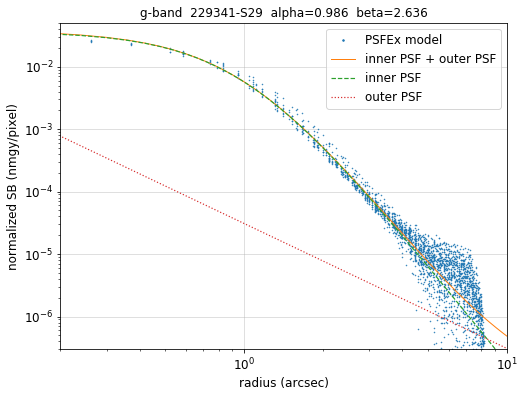

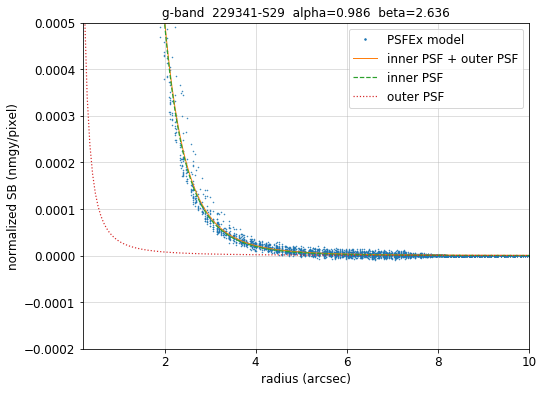

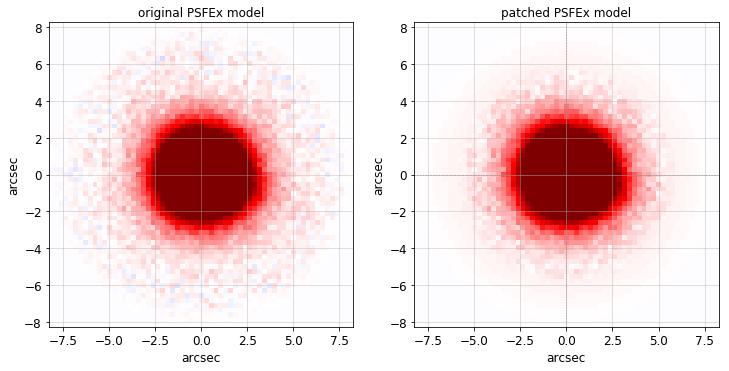

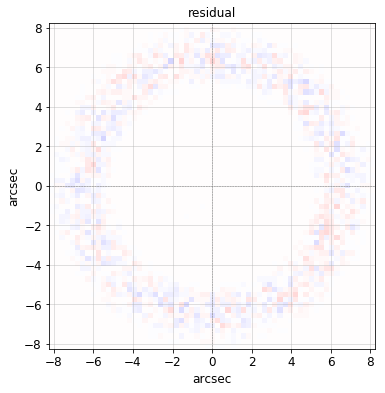

0.000414125
2.66934374604e-08


In [20]:
ccd_index = 0
psf_index = 0

expnum_str = data['expnum'][ccd_index]
ccdname = data['ccdname'][ccd_index]

########## Outer PSF parameters ###########
if band=='z' and (ccdname in outlier_ccd_list):
    params_to_use = params_outlier
    print('OUTLIER!!!!!!!!!')
else:
    params_to_use = params
    
if band!='z':
    plexp2, weight2 = params_to_use[band+'_plexp2'], params_to_use[band+'_weight2']
else:
    alpha2, beta2, weight2 = params_to_use[band+'_alpha2'], params_to_use[band+'_beta2'],  params_to_use[band+'_weight2']

################# PSFEx #################
psfi_original = data['psf_mask'][ccd_index, psf_index]
# normalize to a 22.5 magnitude star
norm_factor = np.sum(psfi_original)
psfi = psfi_original/norm_factor

# vrange = 0.0002
# ax = plot_cutout(psfi, pixscale, vmin=-vrange, vmax=vrange, axis_label=['DEC direction (arcsec)', 'RA direction (arcsec)'])
# plt.show()

grid = pixscale * np.linspace(-0.5*(psfi.shape[0]-1), 0.5*(psfi.shape[0]-1), psfi.shape[0])
xx, yy = np.meshgrid(grid, grid)
radius_grid = np.sqrt(xx**2 + yy**2)
radius = radius_grid.flatten()

################# Moffat fit ##############

radius_min, radius_max = 1.8, 5.0

psfi_flat = psfi.flatten()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # popt, pcov =  curve_fit(get_sb_moffat, radius, psfi_flat/(pixscale**2))
    mask = (radius>radius_min) & (radius<radius_max)
    popt, pcov = curve_fit(get_sb_moffat, radius[mask], psfi_flat[mask]/(pixscale**2), bounds=((0, 1.8), np.inf))

alpha, beta = popt
print('alpha, beta = {:.3f}, {:.3f}'.format(alpha, beta))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    radius_plot = np.linspace(0, 30, 500)
    if band!='z':
        psf_predict = pixscale**2 * get_sb_moffat_plus_power_law(radius_grid, alpha, beta, plexp2, weight2)
        psf_plot = pixscale**2 * get_sb_moffat_plus_power_law(radius_plot, alpha, beta, plexp2, weight2)
        psf_plot1 = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
        psf_plot2 = weight2 * pixscale**2 * radius_plot**(plexp2)
    else:
        psf_predict = pixscale**2 * get_sb_double_moffat(radius_grid, alpha, beta, alpha2, beta2, weight2)
        psf_plot = pixscale**2 * get_sb_double_moffat(radius_plot, alpha, beta, alpha2, beta2, weight2)
        psf_plot1 = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
        psf_plot2 = weight2 * pixscale**2 * get_sb_moffat(radius_plot, alpha2, beta2)

    plt.figure(figsize=(8, 6))
    plt.loglog(radius, psfi_flat, '.', ms=1., label='PSFEx model')
    plt.loglog(radius_plot, psf_plot, '-', lw=1, label='inner PSF + outer PSF')
    plt.loglog(radius_plot, psf_plot1, '--', lw=1.2, alpha=1., label='inner PSF')
    plt.loglog(radius_plot, psf_plot2, ':', lw=1.2, alpha=1., label='outer PSF')
    mask = radius_plot>0.5
    # plt.loglog(radius_plot[mask], 10**(profile_fit(np.log10(radius_plot)))[mask], 'C2--', lw=1.2, label='polynomial')
    plt.axis([0.2, 10, 3e-7, 0.05])
    plt.grid(alpha=0.5)
    plt.xlabel('radius (arcsec)')
    plt.ylabel('normalized SB (nmgy/pixel)')
    plt.title('{}-band  {}-{}  alpha={:.3f}  beta={:.3f}'.format(band, expnum_str, ccdname, alpha, beta))
    plt.legend(markerscale=3)
    plt.show()
    
    plt.figure(figsize=(8, 6))
    plt.plot(radius, psfi_flat, '.', ms=1., label='PSFEx model')
    plt.plot(radius_plot, psf_plot, '-', lw=1, label='inner PSF + outer PSF')
    plt.plot(radius_plot, psf_plot1, '--', lw=1.2, alpha=1., label='inner PSF')
    plt.plot(radius_plot, psf_plot2, ':', lw=1.2, alpha=1., label='outer PSF')
    mask = radius_plot>0.5
    # plt.loglog(radius_plot[mask], 10**(profile_fit(np.log10(radius_plot)))[mask], 'C2--', lw=1.2, label='polynomial')
    plt.axis([0.2, 10, -0.0002, 0.0005])
    plt.grid(alpha=0.5)
    plt.xlabel('radius (arcsec)')
    plt.ylabel('normalized SB (nmgy/pixel)')
    plt.title('{}-band  {}-{}  alpha={:.3f}  beta={:.3f}'.format(band, expnum_str, ccdname, alpha, beta))
    plt.legend(markerscale=3)
    plt.show()

############################# Create hybrid PSF model ####################################

psfi_combine = psfi.copy()

r1, r2 = radius_lim1, radius_lim2
mask = (radius_grid>r1) & (radius_grid<r2)
psfi_combine[mask] = psfi[mask] * (r2-radius_grid[mask])/(r2-r1) \
               + psf_predict[mask] * (radius_grid[mask]-r1)/(r2-r1)

r1, r2 = radius_lim2, radius_lim3
mask = (radius_grid>=r1) & (radius_grid<r2)
psfi_combine[mask] = psf_predict[mask]

r1, r2 = radius_lim3, radius_lim4
mask = (radius_grid>=r1) & (radius_grid<r2)
psfi_combine[mask] = psf_predict[mask] * (r2-radius_grid[mask])/(r2-r1) \
               + 0 * (radius_grid[mask]-r1)/(r2-r1)

mask = (radius_grid>radius_lim4)
psfi_combine[mask] = 0

# restore to the original normalization
psfi_combine = psfi_combine * norm_factor

psf_vrange = 0.00015
plot_cutout_sidebyside(psfi_original, psfi_combine, pixscale, vmin=-psf_vrange, vmax=psf_vrange, figsize=(12, 6), title1='original PSFEx model', title2='patched PSFEx model', crosshair=False, grid=True, axis_label=['arcsec', 'arcsec'])
plt.show()

plot_cutout(psfi_original-psfi_combine, pixscale, vmin=-psf_vrange, vmax=psf_vrange, figsize=(6, 6), title='residual', axis_label=['arcsec', 'arcsec'])
plt.show()

print(np.sum(psfi_original-psfi_combine))

from scipy.optimize import minimize_scalar
func = lambda a: np.sum((a * psfi_combine - psfi_original)**2)
a = minimize_scalar(func).x
print(a-1)

In [21]:
# save the Moffat parameters
data['moffat_alpha'][ccd_index] = alpha
data['moffat_beta'][ccd_index] = beta

__Modify the other PSFEx eigen-images__

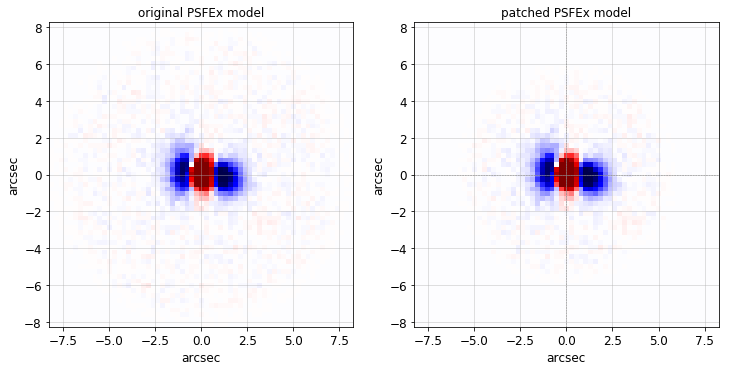

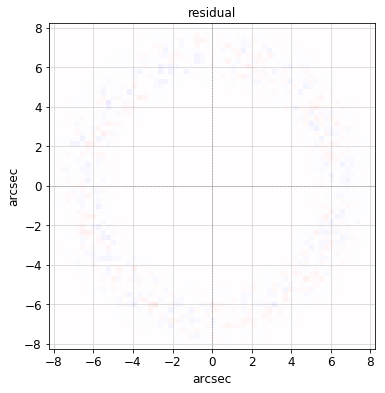

0.000269715


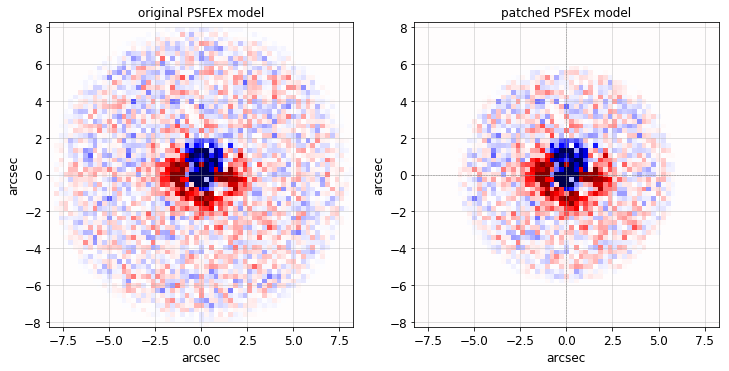

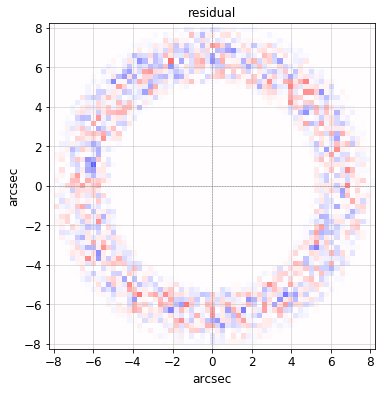

0.00113848


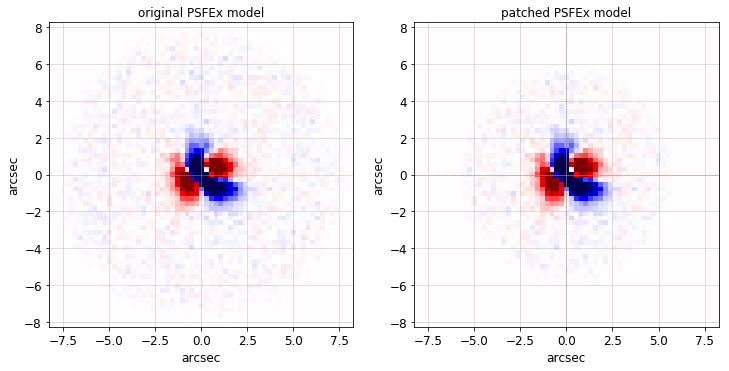

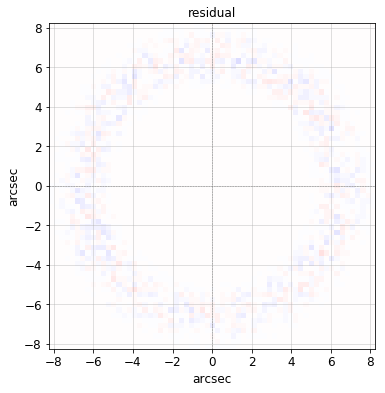

-0.000161775


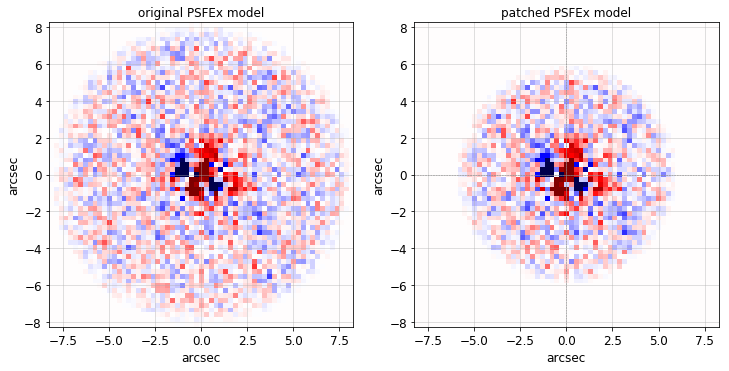

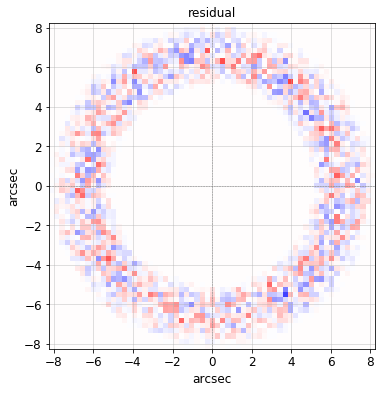

0.00318148


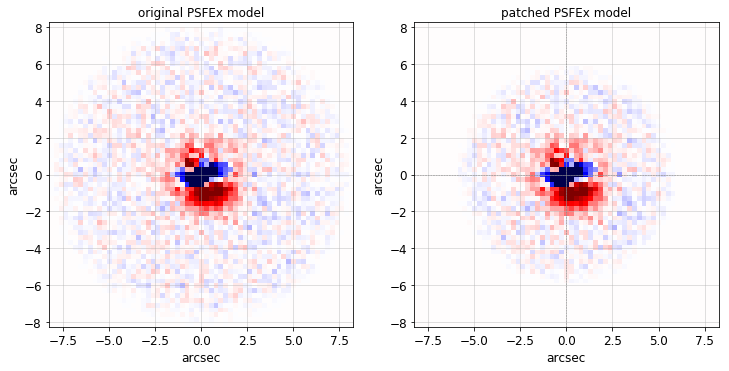

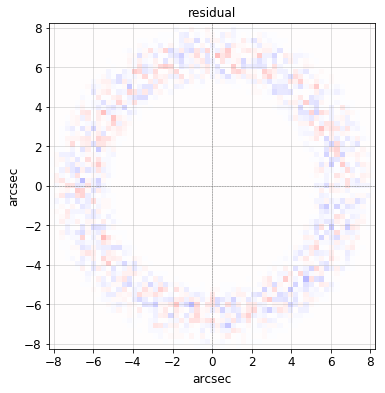

-0.00123312


In [22]:
for psf_index in range(1, 6):

    ################# PSFEx #################
    psfi = data['psf_mask'][ccd_index, psf_index]

    grid = pixscale * np.linspace(-0.5*(psfi.shape[0]-1), 0.5*(psfi.shape[0]-1), psfi.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()

    psfi_combine = psfi.copy()

    r1, r2 = radius_lim1, radius_lim2
    mask = (radius_grid>=r1) & (radius_grid<r2)
    psfi_combine[mask] = psfi[mask] * (r2-radius_grid[mask])/(r2-r1) \
                   + 0 * (radius_grid[mask]-r1)/(r2-r1)

    mask = (radius_grid>radius_lim2)
    psfi_combine[mask] = 0

    psf_vrange = np.std(psfi)*5
    plot_cutout_sidebyside(psfi, psfi_combine, pixscale, vmin=-psf_vrange, vmax=psf_vrange, figsize=(12, 6), title1='original PSFEx model', title2='patched PSFEx model', crosshair=False, grid=True, axis_label=['arcsec', 'arcsec'])
    plt.show()

    plot_cutout(psfi-psfi_combine, pixscale, vmin=-psf_vrange, vmax=psf_vrange, figsize=(6, 6), title='residual', axis_label=['arcsec', 'arcsec'])
    plt.show()

    print(np.sum(psfi-psfi_combine))